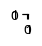

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import itertools
from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

# Redo Models comparison fig without consensus model

In [3]:
def get_fi(fn_dict, key, pdir='../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/'):
    fn = f"featimps_{fn_dict[key]}.csv"
    return pd.read_csv(f'{pdir}{fn}')

def get_pred(evalset, fn_dict, key, pdir='../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/'):
    fn = f"{evalset}_preds_{fn_dict[key]}.csv"
    print(pdir + fn,'\n')
    return pd.read_csv(f'{pdir}{fn}')

cedar_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')

base_model = 'cedar_onehot_None_icore_mut_only_rank'
best_cedar = 'cedar_onehot_Inv-KL_icore_mut_boman-blsm_mut_score-EL_rank_wt_aligned-foreignness_score-Total_Gene_TPM'
best_prime = 'cedar_onehot_KL-Mask_icore_mut_dissimilarity_score-blsm_mut_score-ratio_rank-Total_Gene_TPM'
harmonic = 'cedar_onehot_KL-Mask_icore_mut_dissimilarity_score-blsm_mut_score-Total_Gene_TPM'
compromise = 'cedar_onehot_None_icore_mut_dissimilarity_score-blsm_mut_score-Total_Gene_TPM'
fn_dict = {'base_model':base_model, 'best_cedar':best_cedar, 'best_prime':best_prime, 'harmonic':harmonic, 'compromise':compromise}

best_models = {k:{} for k in fn_dict.keys()}
for k in best_models:
    best_models[k]['featimp'] = get_fi(fn_dict, k)

In [4]:
best_models[k]

{'featimp':           A         R         N         D         C         Q         E  \
 0  0.020963  0.017873  0.011423  0.021914  0.006762  0.016429  0.019456   
 
           G        H         I  ...        P         S         T         W  \
 0  0.015776  0.01666  0.051474  ...  0.02623  0.047917  0.021129  0.011346   
 
           Y         V      rank  icore_dissimilarity_score  \
 0  0.040106  0.043877  0.196533                   0.093611   
 
    icore_blsm_mut_score  Total_Gene_TPM  
 0              0.041905        0.112227  
 
 [1 rows x 24 columns]}

In [5]:
from src.metrics import roc_auc_score
bslmrg = ['Peptide','HLA', 'agg_label', 'EL_rank_mut']

new_nnalign_cedar = pd.read_csv('../../nnalign_cedar/baseline/output_baseline/2305XX_cedar_fold.pep_9174/2305XX_cedar_fold.pep_9174.lg5.sorted.pred', sep='\t').rename(columns={'Prediction':'NNAlign_New'})
new_nnalign_cedar['agg_label'] = new_nnalign_cedar['Measure'].astype(int)

new_nnalign_prime = pd.read_csv('../../benchmark/results/nnalign_newbaseline_lgt5_EVAL_PRIME.txt', sep='\t').rename(columns={'Prediction':'NNAlign_New'})
new_nnalign_prime['agg_label'] = new_nnalign_prime['Measure'].astype(int)

new_nnalign_nepdb = pd.read_csv('../../benchmark/results/nnalign_newbaseline_lgt5_EVAL_NEPDB.txt', sep='\t').rename(columns={'Prediction':'NNAlign_New'})
new_nnalign_nepdb['agg_label'] = new_nnalign_nepdb['Measure'].astype(int)

In [6]:
print('New NNAlign roc scores')
print('cedar', round(roc_auc_score(new_nnalign_cedar['agg_label'], new_nnalign_cedar['NNAlign_New']), 7))
print('prime', round(roc_auc_score(new_nnalign_prime['agg_label'], new_nnalign_prime['NNAlign_New']), 7))
print('nepdb', round(roc_auc_score(new_nnalign_nepdb['agg_label'], new_nnalign_nepdb['NNAlign_New']), 7))

New NNAlign roc scores
cedar 0.6906559
prime 0.6934246
nepdb 0.4383494


In [9]:
cedar_expr_baseline = pd.merge(cedar_baseline[[x for x in cedar_baseline.columns if x not in cedar_aligned_expr.columns or x in bslmrg]], cedar_aligned_expr, left_on=bslmrg, right_on=bslmrg)

assert (new_nnalign_cedar.sort_values(['Peptide','Measure'])['Peptide'].values == cedar_expr_baseline.sort_values(['Peptide','agg_label'])['Peptide'].values).all() and \
       (new_nnalign_cedar.sort_values(['Peptide','Measure'])['agg_label'].values == cedar_expr_baseline.sort_values(['Peptide','agg_label'])['agg_label'].values).all(), 'xd'
cedar_expr_baseline =  pd.merge(new_nnalign_cedar, cedar_expr_baseline, left_on=['Peptide', 'agg_label'], right_on=['Peptide','agg_label']).drop_duplicates(subset=['Peptide','HLA','agg_label']).rename(columns = {'NNAlign_New':'NNAlign_score_new'})


prime_expr_baseline = pd.merge(prime_baseline[[x for x in prime_baseline.columns if x not in prime_aligned_expr.columns or x in bslmrg]], prime_aligned_expr, left_on=bslmrg, right_on=bslmrg)

assert (new_nnalign_prime.sort_values(['Peptide','Measure'])['Peptide'].values == prime_expr_baseline.sort_values(['Peptide','agg_label'])['Peptide'].values).all() and \
       (new_nnalign_prime.sort_values(['Peptide','Measure'])['agg_label'].values == prime_expr_baseline.sort_values(['Peptide','agg_label'])['agg_label'].values).all(), 'xd'
prime_expr_baseline = pd.merge(prime_expr_baseline.sort_values(['Peptide','agg_label']), new_nnalign_prime.sort_values(['Peptide','Measure'])[['NNAlign_New']], left_index=True, right_index=True).rename(columns = {'NNAlign_New':'NNAlign_score_new'})

In [10]:
print(round(roc_auc_score(cedar_expr_baseline['agg_label'], cedar_expr_baseline['NNAlign_score_new']),7)==round(roc_auc_score(new_nnalign_cedar['agg_label'], new_nnalign_cedar['NNAlign_New']), 7))
print(round(roc_auc_score(prime_expr_baseline['agg_label'], prime_expr_baseline['NNAlign_score_new']),7)==round(roc_auc_score(new_nnalign_prime['agg_label'], new_nnalign_prime['NNAlign_New']), 7))

True
True


In [11]:
# Reget preds 
cp_common_peps = [x for x in cedar_expr_baseline.Peptide.values if x in prime_expr_baseline.Peptide.values]
rebootstrapped_best = {}
for evalset, df_baseline in zip(['cedar', 'prime'],
                            [cedar_expr_baseline, prime_expr_baseline]):
    tmp = []
    for k in best_models:
        if evalset=='prime':
            best_models[k][evalset] = get_pred(evalset, fn_dict, k).query('Peptide not in @cp_common_peps')
        else:
            best_models[k][evalset] = get_pred(evalset, fn_dict, k)
            
        pcol = 'pred' if 'pred' in best_models[k][evalset].columns else 'mean_pred'
        scores = best_models[k][evalset][pcol].values
        labels = best_models[k][evalset]['agg_label'].astype(int).values
        bootstrapped_df = bootstrap_eval(scores, labels, n_rounds=10000, n_jobs=8).assign(evalset=evalset, key=k)
        print(k,evalset, 'mean:', round(bootstrapped_df['auc'].mean(),4), 'median:',round(bootstrapped_df['auc'].median(),4))
        tmp.append(bootstrapped_df)
        
    peps=best_models[k][evalset].Peptide.values
    if evalset=='prime':
        evalset_copy = df_baseline.query('Peptide not in @cp_common_peps and Peptide in @peps')
    else:
        evalset_copy = df_baseline.copy('Peptide in @peps')
    # Bootstrap PRIME and NN align as baseline on the boxplots?    
    for baseline in list(filter( lambda x: 'score' in x.lower() and ('prime' in x.lower() or 'nnalign' in x.lower()) , df_baseline.columns)):
        scores = evalset_copy[baseline].values
        labels = evalset_copy['agg_label'].astype(int).values
        bootstrapped_baseline = bootstrap_eval(scores, labels, n_rounds=10000, n_jobs=8).assign(evalset=evalset, key=baseline)
        tmp.append(bootstrapped_baseline)
    rebootstrapped_best[evalset] = pd.concat(tmp)


../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/cedar_preds_cedar_onehot_None_icore_mut_only_rank.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
base_model cedar mean: 0.7194 median: 0.7194
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/cedar_preds_cedar_onehot_Inv-KL_icore_mut_boman-blsm_mut_score-EL_rank_wt_aligned-foreignness_score-Total_Gene_TPM.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
best_cedar cedar mean: 0.7417 median: 0.7418
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/cedar_preds_cedar_onehot_KL-Mask_icore_mut_dissimilarity_score-blsm_mut_score-ratio_rank-Total_Gene_TPM.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
best_prime cedar mean: 0.7123 median: 0.7125
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/cedar_preds_cedar_onehot_KL-Mask_icore_mut_dissimilarity_score-blsm_mut_score-Total_Gene_TPM.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
harmonic cedar mean: 0.7182 median: 0.7184
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/cedar_preds_cedar_onehot_None_icore_mut_dissimilarity_score-blsm_mut_score-Total_Gene_TPM.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
compromise cedar mean: 0.7279 median: 0.728
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/prime_preds_cedar_onehot_None_icore_mut_only_rank.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
base_model prime mean: 0.693 median: 0.6944
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/prime_preds_cedar_onehot_Inv-KL_icore_mut_boman-blsm_mut_score-EL_rank_wt_aligned-foreignness_score-Total_Gene_TPM.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
best_cedar prime mean: 0.6539 median: 0.6548
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/prime_preds_cedar_onehot_KL-Mask_icore_mut_dissimilarity_score-blsm_mut_score-ratio_rank-Total_Gene_TPM.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
best_prime prime mean: 0.7214 median: 0.7225
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/prime_preds_cedar_onehot_KL-Mask_icore_mut_dissimilarity_score-blsm_mut_score-Total_Gene_TPM.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
harmonic prime mean: 0.7208 median: 0.7219
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/prime_preds_cedar_onehot_None_icore_mut_dissimilarity_score-blsm_mut_score-Total_Gene_TPM.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
compromise prime mean: 0.7097 median: 0.7109
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [12]:
display(rebootstrapped_best['cedar'].groupby('key').agg(mean_auc=('auc', 'mean'),
                                                mean_auc01=('auc_01','mean')))
display(rebootstrapped_best['prime'].groupby('key').agg(mean_auc=('auc', 'mean'),
                                                mean_auc01=('auc_01','mean')))


,mean_auc,mean_auc01
key,,
NNAlign_score_new,0.690832,0.550090
PRIME_score,0.659433,0.541878
base_model,0.719448,0.581625
best_cedar,0.741664,0.586496
best_prime,0.712337,0.569128
compromise,0.727866,0.576827
harmonic,0.718216,0.568988
nnalign_score,0.680962,0.554611


,mean_auc,mean_auc01
key,,
NNAlign_score_new,0.631818,0.531504
PRIME_score,0.709605,0.581538
base_model,0.692971,0.572050
best_cedar,0.653946,0.530852
best_prime,0.721371,0.615861
compromise,0.709702,0.576791
harmonic,0.720788,0.599151
nnalign_score,0.608276,0.519226


In [13]:
def rename_models(key):
    return {'base_model': 'Base Model',
            'best_cedar' : 'Optimal CEDAR Model',
            'best_prime': 'Optimal PRIME Model',
            'harmonic': 'Consensus Model',
            'compromise': 'Compromise Model',
            'nnalign_score':'NNAlign',
            'NNAlign_score_new': 'NNAlign_New',
            'PRIME_score': 'PRIME'}[key]

rebootstrapped_best['cedar']['Model'] = rebootstrapped_best['cedar']['key'].apply(rename_models)
rebootstrapped_best['prime']['Model'] = rebootstrapped_best['prime']['key'].apply(rename_models)


In [149]:
sns.set_style('darkgrid')

0.0
9.999999999998899e-05


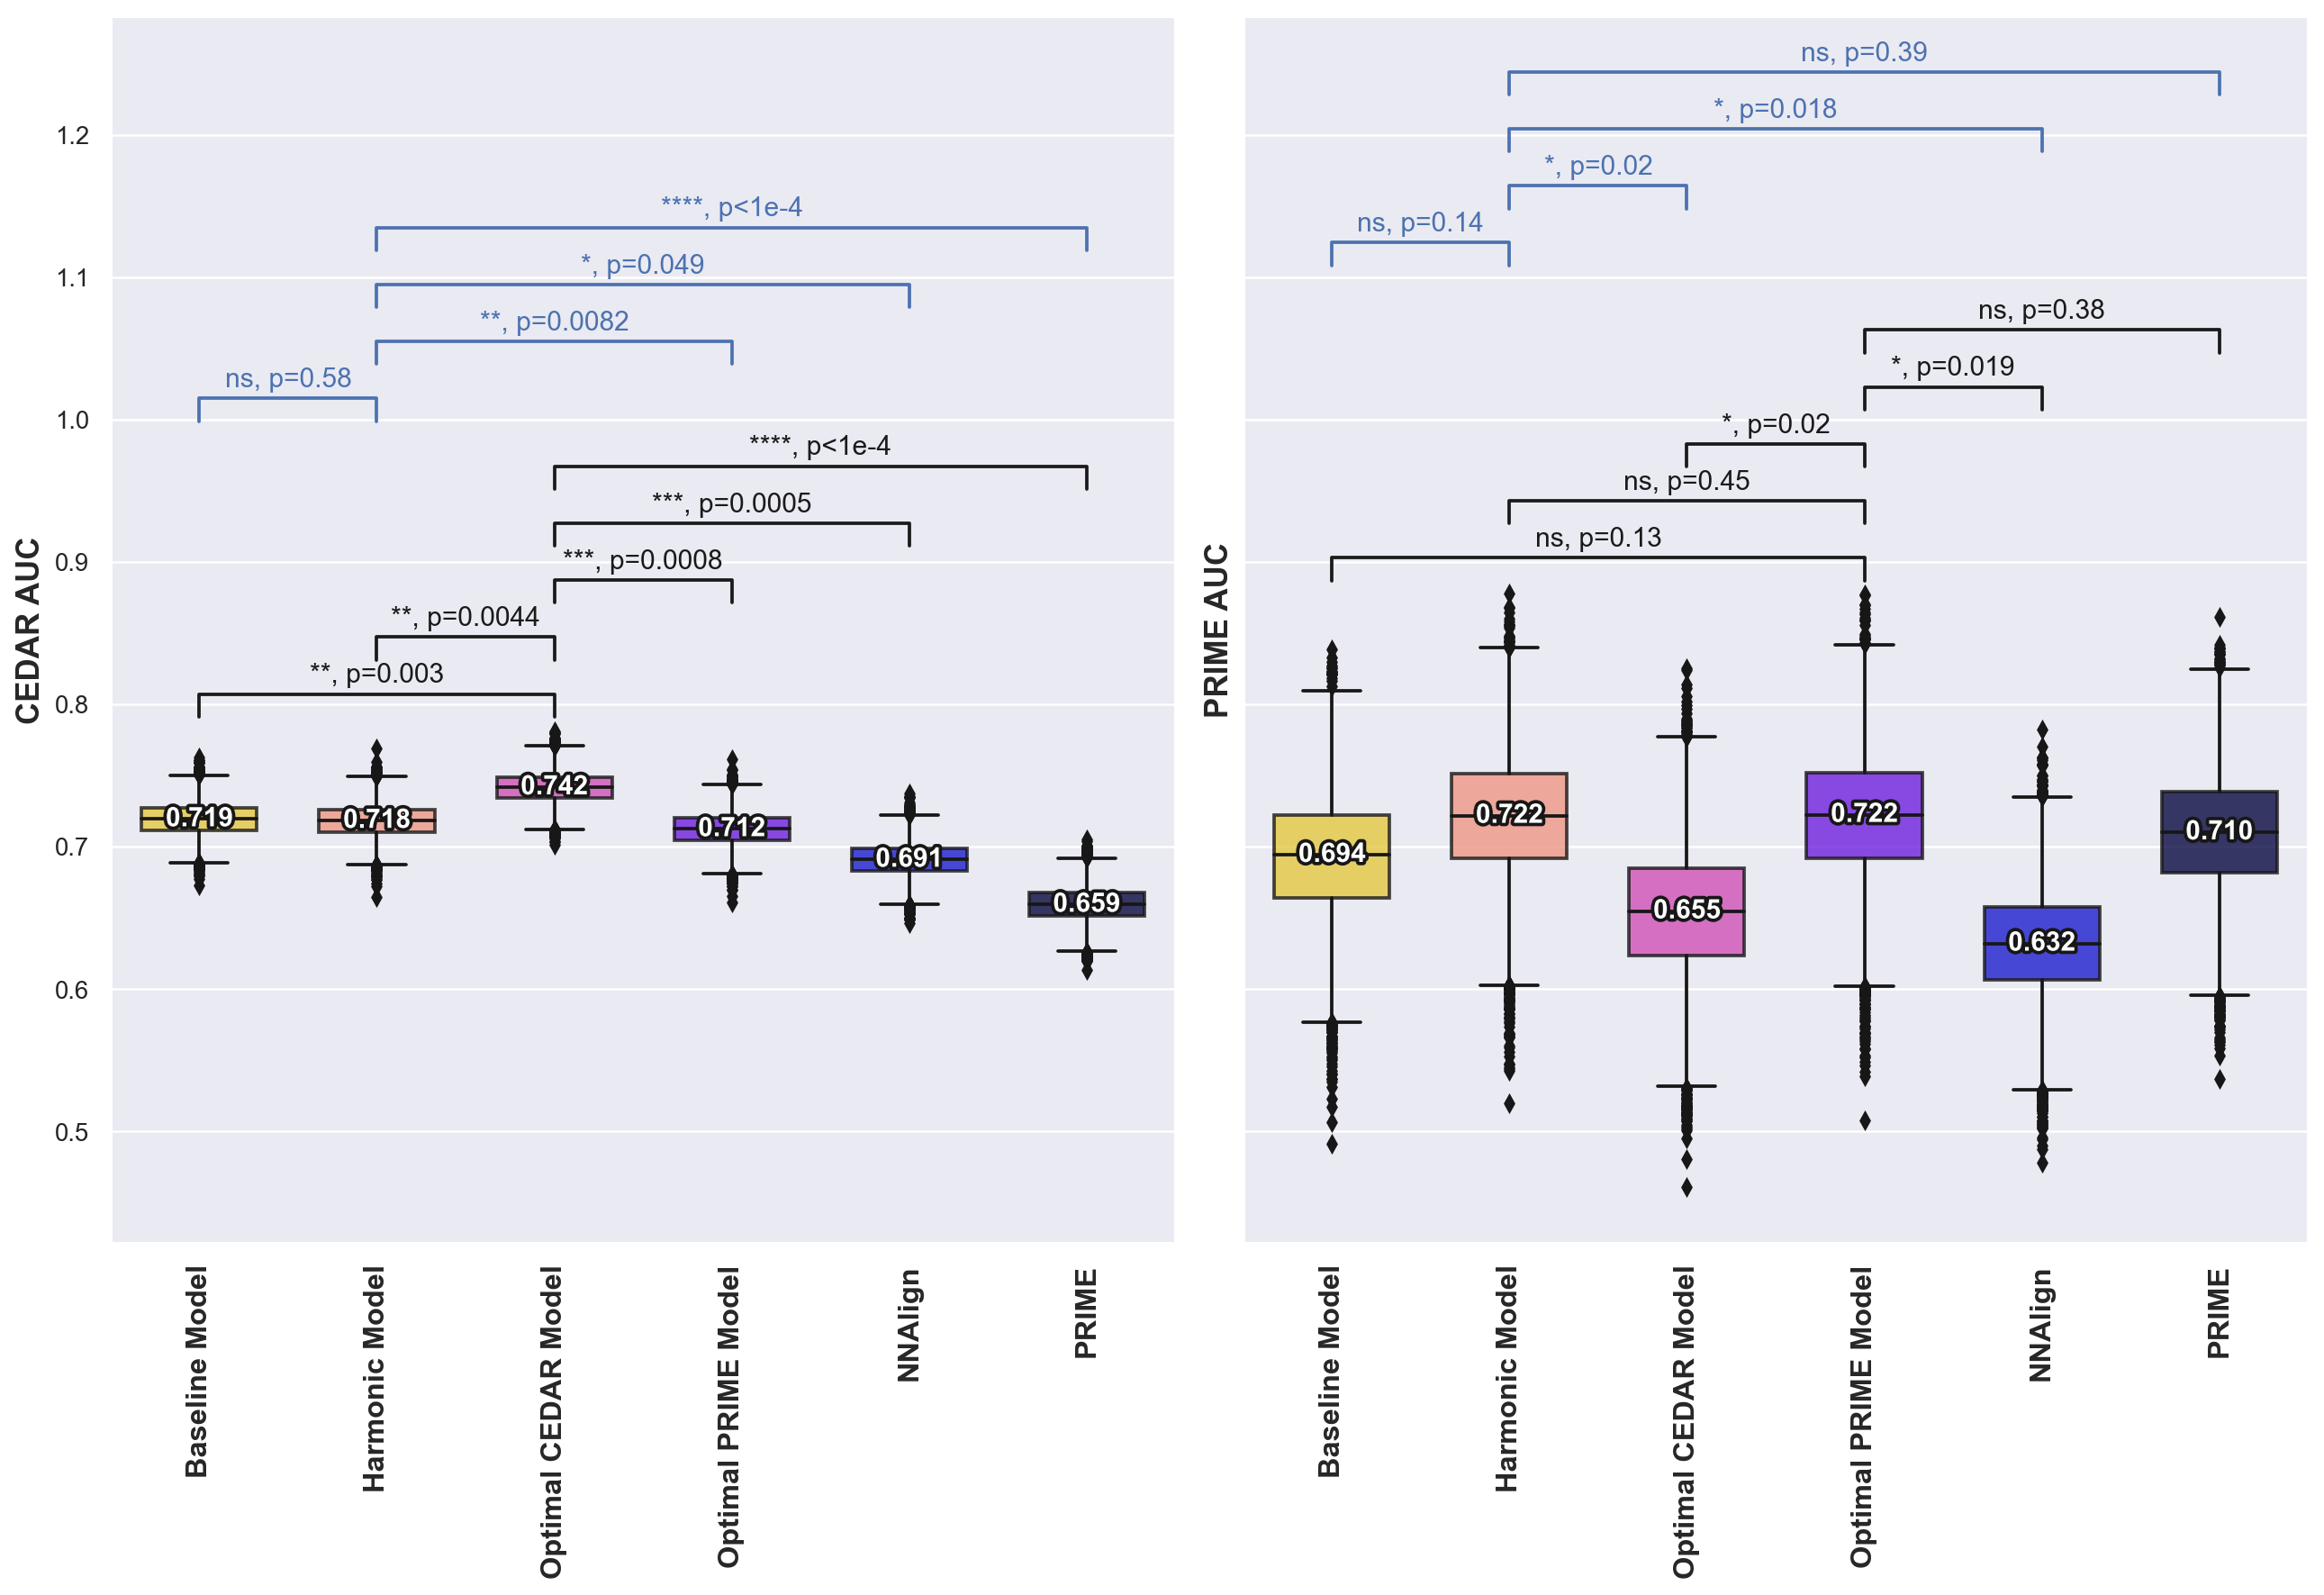

In [1348]:
from src.bootstrap import get_pval, plot_pval, get_pval_wrapper
sns.set_style('darkgrid')
# Redo the plot but keeping the order and redo not all the p-values, using the new features (i.e. including foreignness score etc)
f,a = plt.subplots(1,2, figsize=(14.5,10), sharey=True)
order = ['Baseline Model','Harmonic Model', 'Optimal CEDAR Model', 'Optimal PRIME Model', 'NNAlign', 'PRIME']

color_order = {k:v for k,v in zip(order, get_palette('gnuplot2_r', n_colors=len(order)))}
for evalset,axis in zip(rebootstrapped_best, a):
    tmp = rebootstrapped_best[evalset].copy().replace({'NNAlign_New':'NNAlign', 'Base Model': 'Baseline Model'}).query('key!="nnalign_score"')
    sorted_order = tmp.groupby('Model').agg(mean_auc=('auc','mean'))\
                      .sort_values('mean_auc', ascending=False).index.tolist()
    # Sort order by decreasing performance
    sns.boxplot(data = tmp , x = 'Model', y = 'auc', width=.65, ax=axis, 
                palette = color_order, order = order, hue_order=order, hue = 'Model', dodge=False)
    # Add median and remove legend / ylabel
    add_median_labels(axis, fmt = '.3f');
    axis.set_ylabel(f'{evalset.upper()} AUC', fontweight='semibold', fontsize=14);
    axis.set_xlabel('');
    axis.set_xticklabels(axis.get_xticklabels(), fontweight = 'semibold', 
                         fontsize=13, rotation=90, ha='center')
    # axis.set_xticklabels([])
    # axis.set_title(f'Performance of models on {evalset.upper()} ', fontweight='semibold')
    # Comparing with aucs_base, which is the best one
    best = f'Optimal {evalset.upper()} Model'
    aucs_base = tmp.query('Model == @best')
    h, h0 = 0.01, 0.02
    x0 = order.index(best)
    plt.setp(axis.patches, alpha=0.8)
    comp_list = reversed([x for x in order if x != best]) if x0 >= 4 else [x for x in order if x != best]
    for i, comparison in enumerate(comp_list):
        x1 = order.index(comparison)
        aucs_comp = tmp.query('Model == @comparison')
        pval, sig = get_pval_wrapper(aucs_base, aucs_comp)
        # print(evalset,best, 'here',comparison, round(pval,3))
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_base.auc)+h, h=h0, color='k')
        h += 2 * h0
        
    # Comparing "agg_selection" with the lower 2
    new_order = [x for x in order if x != best and x != 'Harmonic Model']
    new_order = ['Harmonic Model'] + new_order
    aucs_har = tmp.query('Model == "Harmonic Model"')
    x0 = order.index('Harmonic Model')
    h += 1*h0
    for i, comparison in enumerate(new_order[1:]):
        x1 = order.index(comparison)
        aucs_comp = tmp.query('Model == @comparison')
        pval, sig = get_pval_wrapper(aucs_har, aucs_comp)
        # print(evalset,best, 'there',comparison, round(pval,3))
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_har.auc)+h, h=h0, color = 'b')
        h += 2*h0
# a[0].set_ylabel('AUC', fontweight='semibold', fontsize=13);

# Just re-order legend because it got messed up for some reasons
# h, l = a[1].get_legend_handles_labels()
# new_h = [h.pop(l.index('Base Model')), h.pop(l.index('Harmonic Model'))]
# new_l = [l.pop(l.index('Base Model')), l.pop(l.index('Harmonic Model'))]
# new_h.extend(h)
# new_l.extend(l)

bbox = (0, 0.59)
a[0].legend([], frameon=False);
a[1].legend([], frameon=False);
# a[1].legend(bbox_to_anchor = bbox,prop=dict(weight='semibold', size = 14));
f.tight_layout()
# NUMBER PRINTED IS NOT THE MEAN BUT THE MEDIAN THAT'S WHY THEY ARE DIFFERENT FROM THE DF
f.savefig('../../../writing/230131_cedar_paper_1/figures/2305XX_FINAL_redone_best_models_compromise_WITHCEDARFILTERING.png', bbox_inches='tight', dpi=200)

0.0


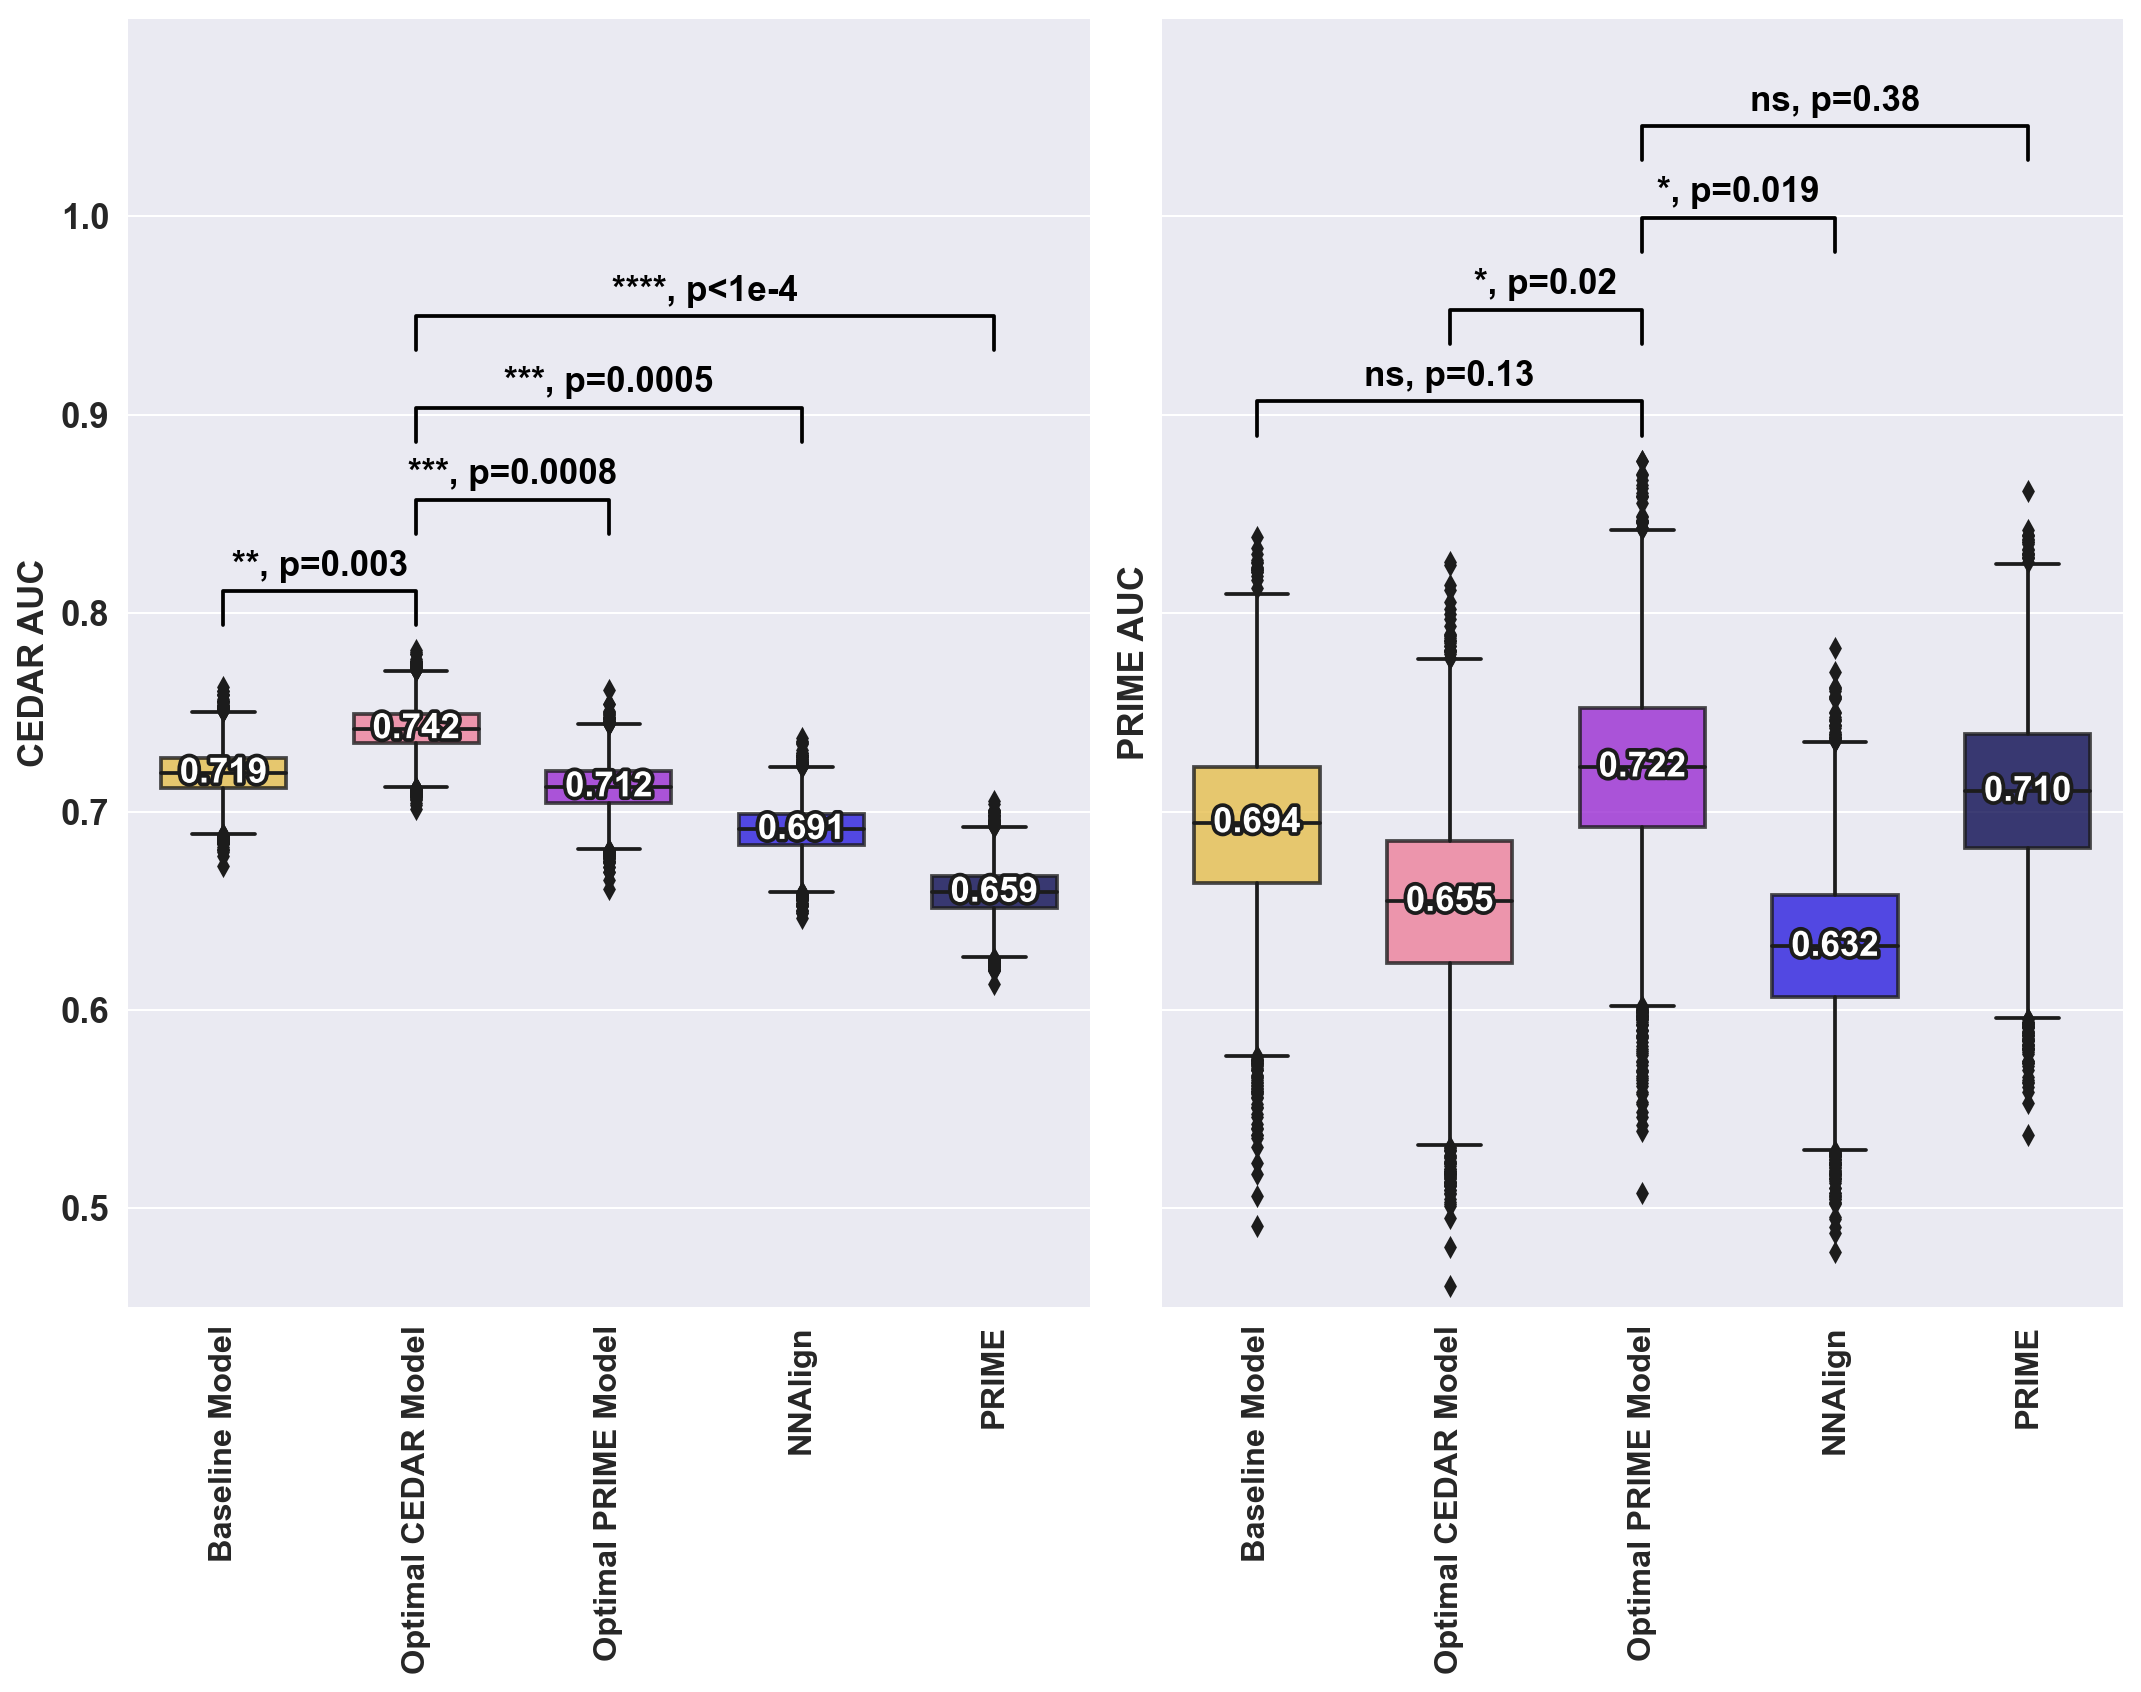

In [29]:
# REMAKE BIGGER
from src.bootstrap import get_pval, plot_pval, get_pval_wrapper
sns.set_style('darkgrid')
# Redo the plot but keeping the order and redo not all the p-values, using the new features (i.e. including foreignness score etc)
f,a = plt.subplots(1,2, figsize=(12,9.5), sharey=True)
order = ['Baseline Model', 'Optimal CEDAR Model', 'Optimal PRIME Model', 'NNAlign', 'PRIME']

color_order = {k:v for k,v in zip(order, get_palette('gnuplot2_r', n_colors=len(order)))}
for evalset,axis in zip(rebootstrapped_best, a):
    tmp = rebootstrapped_best[evalset].copy().replace({'NNAlign_New':'NNAlign', 
                                                       'Harmonic Model':'Consensus Model',
                                                       'Base Model': 'Baseline Model'}).query('key!="nnalign_score"')
    sorted_order = tmp.groupby('Model').agg(mean_auc=('auc','mean'))\
                      .sort_values('mean_auc', ascending=False).index.tolist()
    # Sort order by decreasing performance
    sns.boxplot(data = tmp , x = 'Model', y = 'auc', width=.65, ax=axis, 
                palette = color_order, order = order, hue_order=order, hue = 'Model', dodge=False)
    # Add median
    add_median_labels(axis, fmt = '.3f', fontsize=14);
    
    # Comparing with aucs_base, which is the best one
    best = f'Optimal {evalset.upper()} Model'
    aucs_base = tmp.query('Model == @best')
    h, h0 = 0.01265, 0.0215
    x0 = order.index(best)
    plt.setp(axis.patches, alpha=0.8)
    comp_list = reversed([x for x in order if x != best]) if x0 >= 4 else [x for x in order if x != best]
    for i, comparison in enumerate(comp_list):
        x1 = order.index(comparison)
        aucs_comp = tmp.query('Model == @comparison')
        pval, sig = get_pval_wrapper(aucs_base, aucs_comp)        
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_base.auc)+h, h=h0, 
                  fontweight='semibold', fontsize=14, color='k')
        h += 2.15 * h0
    # Adjust Y/X ticks
    axis.set_ylim([0.45, 1.1])
    yticks = np.arange(0.5, 1.05, 0.1)
    yticklabels = [f'{x:.1f}' for x in yticks]
    axis.set_yticks(yticks)
    axis.set_yticklabels(yticklabels, fontweight='semibold', fontsize=14)
    axis.set_ylabel(f'{evalset.upper()} AUC', fontweight='semibold', fontsize=14);
    # axis.set_ylabel('');
    axis.set_xlabel('');
    axis.set_xticklabels(axis.get_xticklabels(), fontweight = 'semibold', 
                         fontsize=13, rotation=90, ha='center')
    
# a[0].text(0.0055, 0.9425, 'A', fontsize=34, fontweight='bold', transform=a[0].transAxes)
# a[1].text(0.0055, 0.9425, 'B', fontsize=34, fontweight='bold', transform=a[1].transAxes)
 
bbox = (0, 0.59)
a[0].legend([], frameon=False);
a[1].legend([], frameon=False);f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/submission_nar/figures_redo/FIG6_bestmodels_redo.png',
                                                         bbox_inches='tight', dpi=600)

# Re-make / do viral featimp script thing with merged dataset

In [47]:
viral = pd.read_csv('../data/neoepi_viral/viral.csv')
cedar = pd.read_csv('../data/neoepi_viral/cedar.csv')
merged = pd.read_csv('../data/pepx/231018_cedar_prime_merged_fold.csv')

In [53]:
merged[['icore_mut','HLA', 'EL_rank_mut', 'agg_label']].rename(columns = {'icore_mut':'sequence'})

,sequence,HLA,EL_rank_mut,agg_label
0,AAAAAAAVL,HLA-B0702,0.9883,0
1,AAAAAAAVL,HLA-B0702,0.9883,0
2,AAAAAAQQI,HLA-B0702,3.9712,0
3,AAAALHMQR,HLA-A1101,0.3609,0
4,AAAAQQIQV,HLA-B0702,4.9092,0
...,...,...,...,...
5414,YYNFEGDIALL,HLA-A2402,0.6247,0
5415,YYPGKKEPF,HLA-A2402,0.0965,0
5416,YYSKNLNSF,HLA-A2402,0.0033,1
5417,YYSKNLNSF,HLA-A2402,0.0033,1


In [51]:
merged[['icore_mut','HLA', 'EL_rank_mut', 'agg_label']].rename(columns = {'icore_mut':'sequence'}).to_csv('../data/neoepi_viral/merged.csv', index=False)

# Redo feat imp figure

In [42]:
fi_harmonic = pd.read_csv('../output/231018_redo_merged/new_best_model/featimps_cp_merged_onehot_KL_icore_mut_boman-blsm_mut_score-Total_Gene_TPM.csv')

def rename(col):
    d = {'icore_boman':'Boman Index',
         'icore_blsm_mut_score':'BLSM Mut Score',
         'EL_rank_wt_aligned': 'WT %Rank',
         'rank': 'MUT %Rank',
         'foreignness_score': 'Foreignness',
         'Total_Gene_TPM' : 'Expression',
         'icore_dissimilarity_score':'Self-Similarity',
         'ratio_rank': 'Agretopicity'}
    if col in d.keys():
        return d[col]
    else:
        return col

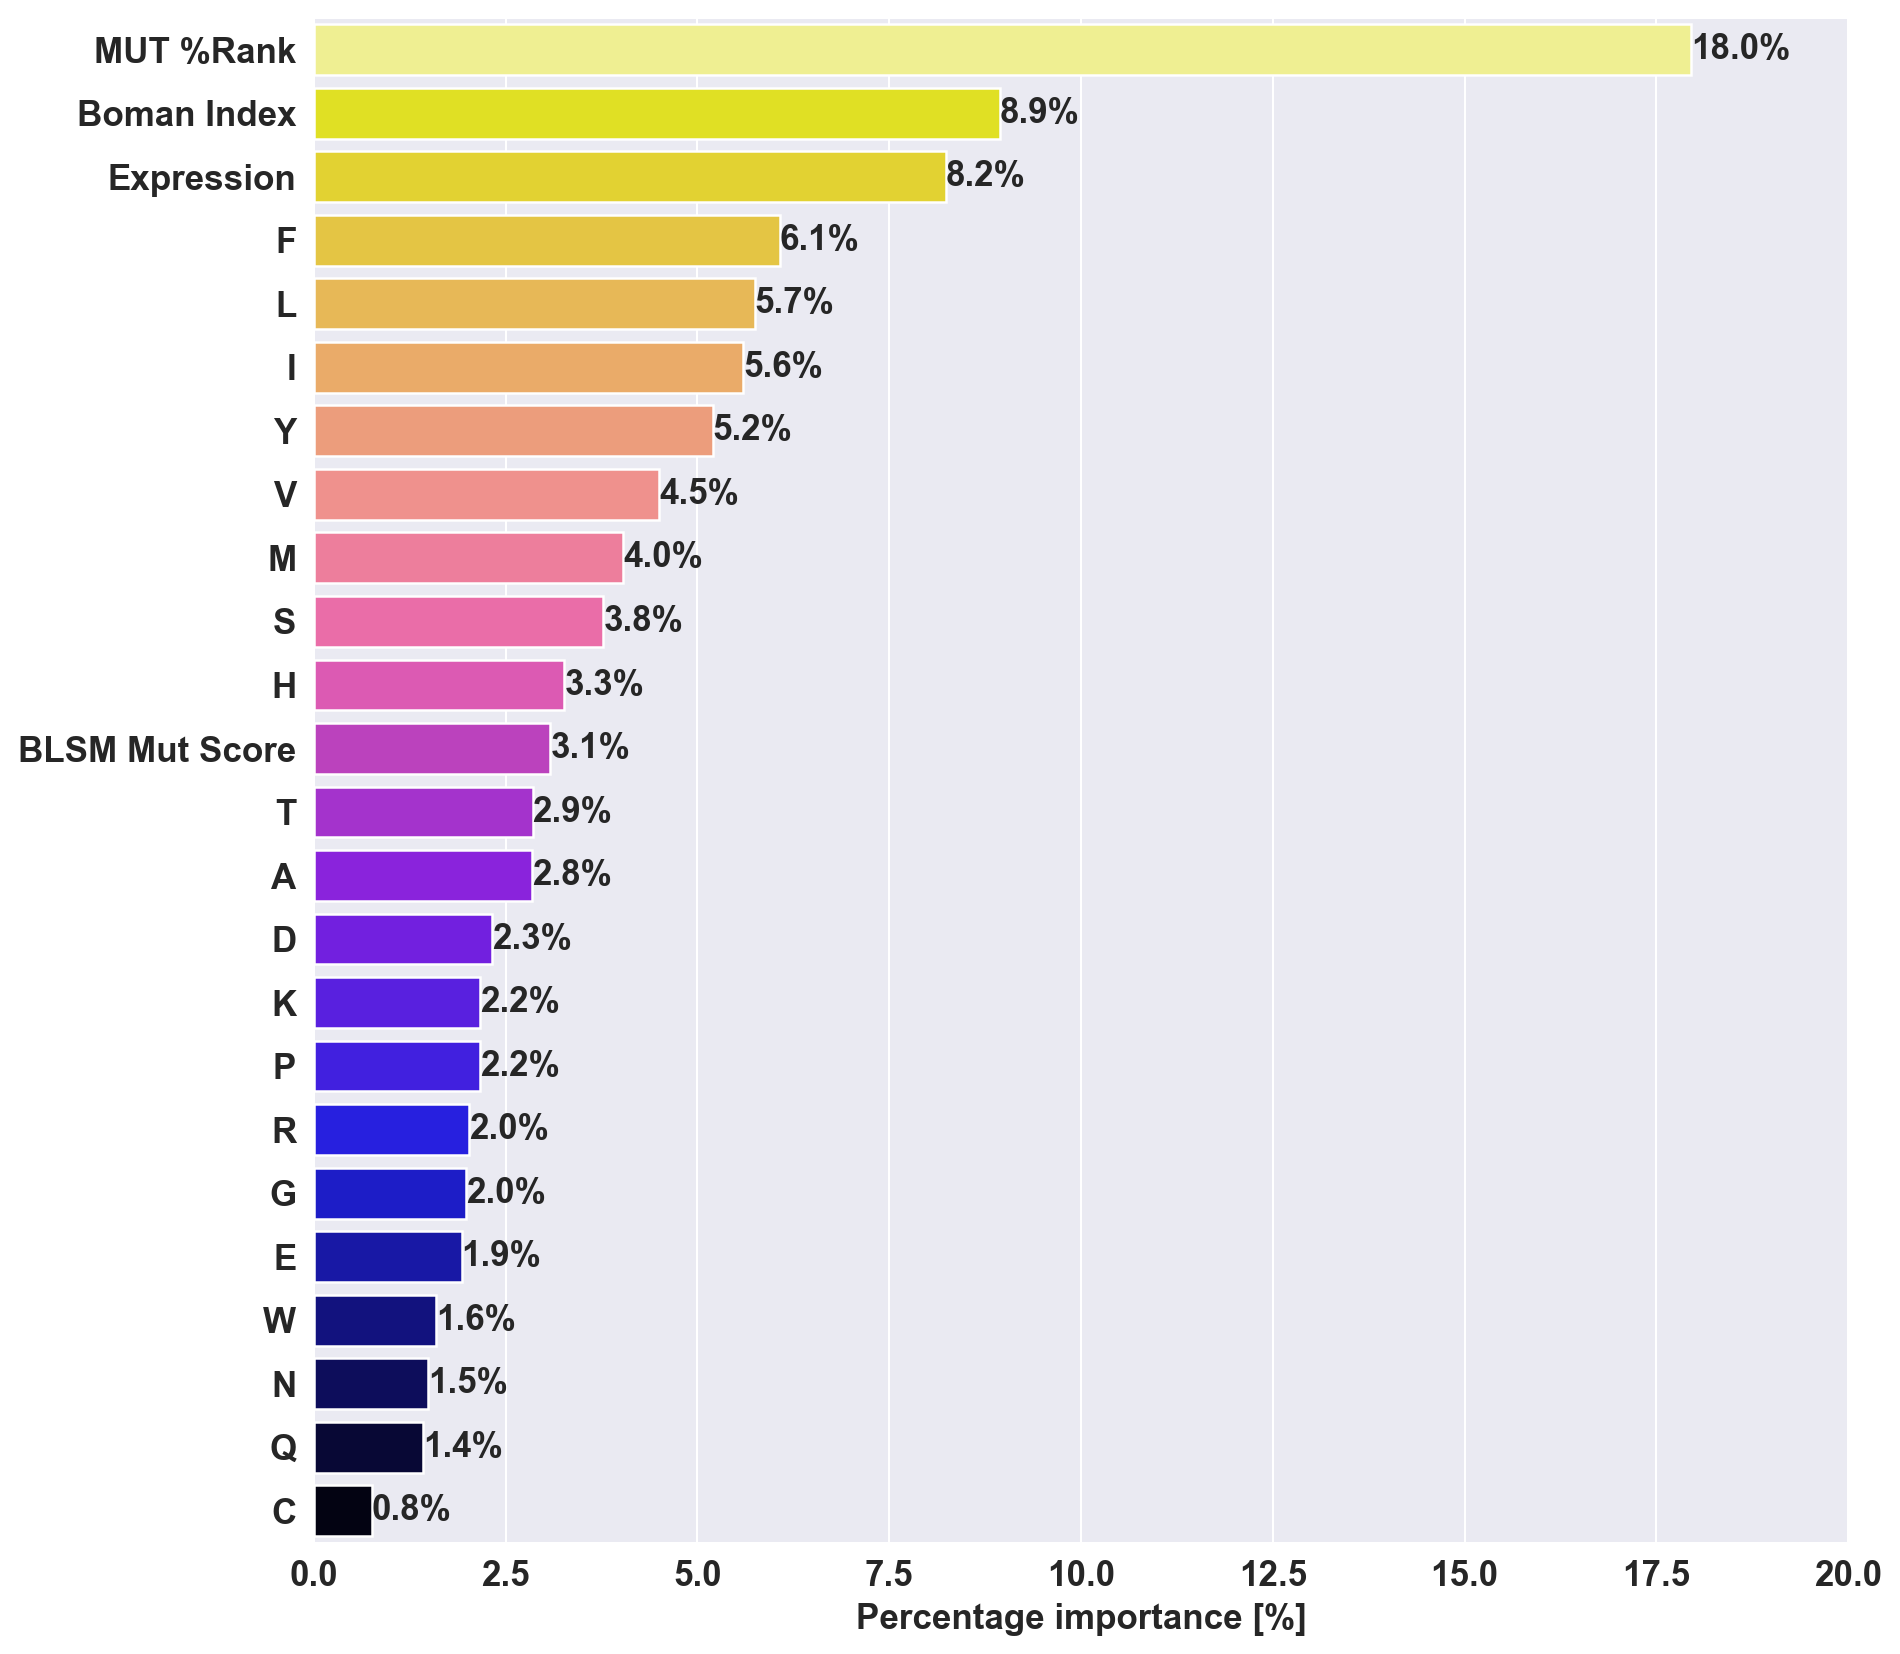

In [44]:
# Remaking bigger, only harm here
from src.metrics import plot_feature_importance
f,a = plt.subplots(1,1, figsize=(11,11.))

                        
plot_feature_importance(fi_harmonic.values.flatten(), 
                        list(map(rename,fi_harmonic.columns)), 
                        palette='gnuplot2_r', ax=a, 
                        label_number=True)
a.set_ylabel('')
a.set_xlabel('Percentage importance [%]', fontsize=14, fontweight='semibold')
a.set_yticklabels(a.get_yticklabels(), fontsize=14, fontweight='semibold')
a.set_xticklabels(a.get_xticklabels(), fontsize=14, fontweight='semibold')
a.set_xlim([0.,0.2])
f.savefig('../../../writing/230131_cedar_paper_1/submission_nar/figures_redo/FIG7_ONLYHARM_FeatImps.png', bbox_inches='tight', dpi=600)


# Redo benchmark plots with the new model